In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from math import pi
rng = np.random.default_rng(4)  # the most random number/ the constructor for creating random numbers
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

In [11]:
# Checking data recursion limit
import sys

print('The recusion limit is', sys.getrecursionlimit())

# Setting to higher recusion limit so that f1 accuracy can be computed
sys.setrecursionlimit(1500)

The recusion limit is 1500


In [12]:

# Store data (Github Version)
df = pd.read_csv("./data/mushrooms.csv")

# preprocess the data (one-hot encoding)
df_clean = pd.get_dummies(df.drop(columns=['class']), df.columns[1:]).join(df['class'] == 'e')
df_clean

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,class
0,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,True,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
2,True,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,True
3,False,False,False,False,False,True,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,True,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,False,False,False,True,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
8120,False,False,False,False,False,True,False,False,True,False,...,True,False,False,False,True,False,False,False,False,True
8121,False,False,True,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
8122,False,False,False,True,False,False,False,False,False,True,...,True,False,False,False,True,False,False,False,False,False


In [13]:
##########################################################################################
# Functions for evaluation
##########################################################################################

def confusion_matrix(y_true, y_pred, pos_label=1):
    """
    Calculates the confusion matrix of true vs predicted labels
    :param y_true: True labels
    :param y_pred: Predicted labels
    :return: Confusion matrix in the form of a 2x2 np.array
    """
    tp = np.sum((y_true == pos_label) & (y_pred == pos_label))
    fp = np.sum((y_true != pos_label) & (y_pred == pos_label))
    fn = np.sum((y_true == pos_label) & (y_pred != pos_label))
    tn = np.sum((y_true != pos_label) & (y_pred != pos_label))
    return np.array([[tp, fn], [fp, tn]])


def accuracy_score(y_true, y_pred, pos_label=1):
    """
    Calculates the accuracy of the predictions
    :param y_true: True labels
    :param y_pred: Predicted labels
    :return: Accuracy as a float between 0 and 1
    """
    cm = confusion_matrix(y_true, y_pred, pos_label=pos_label)
    [[tp, fn], [fp, tn]] = cm  # use if desired
    acc = np.sum(np.diag(cm)) / np.sum(cm)
    return acc



def roc_curve(y_true, y_score):
    """
    Calculates the receiver operating characteristic (ROC) curve
    :param y_true: True labels
    :param y_score: Model score/probability for the positive class
    thresholds (list): thresholds used for decision making
    :return: False Positive Rate (FPR), True Positive Rate (TPR) as np.arrays
    """
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    thresholds = np.unique(y_score)[::-1]  # reverse: from high threshold to low

    fpr = [0]  # with a maximum threshold, there are no positive predictions
    tpr = [0]
    for threshold in thresholds:
        y_pred = (y_score >= threshold)
        [[tp, fn], [fp, tn]] = confusion_matrix(y_true, y_pred)
        fpr.append(fp / (fp + tn))
        tpr.append(tp / (tp + fn))

    fpr = np.array(fpr)  # convert to numpy
    tpr = np.array(tpr)
    return fpr, tpr, thresholds

/Users/jeremyolliffe/git/Yummi305/mushroomHarvest/.conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-Means Confusion Matrix:
[[823   8]
 [165 629]]
LogRegression Confusion Matrix:
[[831   0]
 [  0 794]]
K-Means Accuracy: 0.8935384615384615
LogRegression Accuracy: 1.0
LogRegression F1 Weighted Score:  0.8922927376654597
LogRegression F1 Weighted Score:  1.0
Kmeans Jaccard Similarity Score: 0.8057755842090788
LogRegression Jaccard Similarity Score: 1.0


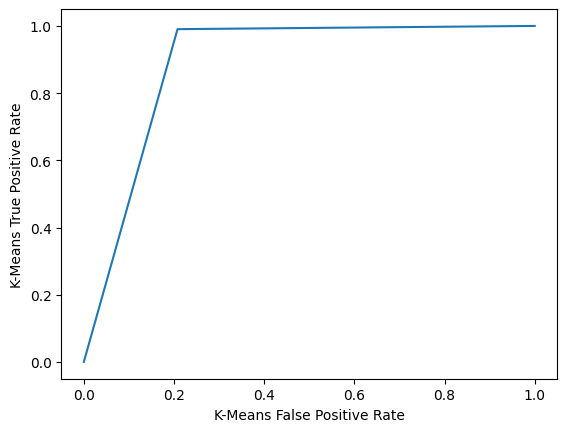

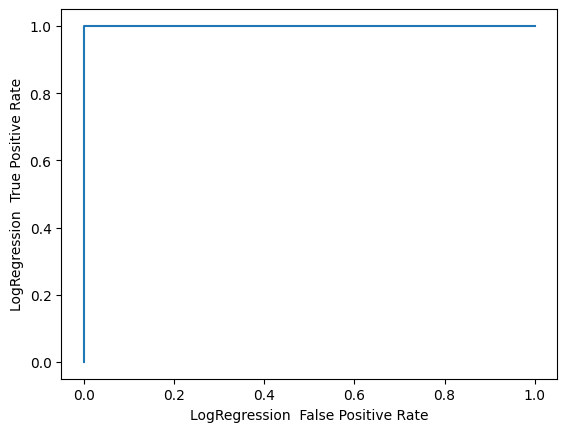

In [14]:
##########################################################################################
# K-MEANS and LOG LogisticRegression + Results
##########################################################################################

# store the data
# df = pd.read_csv('mushrooms.csv')

# preprocess the data (one-hot encoding)
classes = df['class']
features = df.drop(columns=['class'])
features = pd.get_dummies(features)

# split into X and Y
X = features
# 1 is edible, 0 is poisonous
Y = classes == 'e'

# split into training and testing data, 20% split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# initialise models
noOfClusters = 2
kmeans = KMeans(n_clusters = noOfClusters)
logreg = LogisticRegression()

# train models using training data
kmeans.fit(X_train)
logreg.fit(X_train, y_train)


# get predictions
kmeans_pred = kmeans.predict(X_test)
logreg_pred = logreg.predict(X_test)

# k-means sometimes has its moment and flips predictions ie cluster names
# find its reverse and pick the correct combination
kmeans_pred_reverse = []
for x in kmeans_pred:
    if x == 1:
        kmeans_pred_reverse.append(0)
    elif x == 0:
        kmeans_pred_reverse.append(1)
kmeans_pred_reverse = np.array(kmeans_pred_reverse)

if accuracy_score(y_test, kmeans_pred) < accuracy_score(y_test, kmeans_pred_reverse):
    kmeans_pred = kmeans_pred_reverse

# reuslts - group together into a dataFrame
result_df = pd.DataFrame()
result_df['y_test'] = np.array(y_test)
result_df['kmeans_pred'] = kmeans_pred
result_df['kmeans_correct'] = result_df['kmeans_pred'] == result_df['y_test'] # correct when pred == actual
result_df['logreg_pred'] = logreg_pred
result_df['logreg_correct'] = result_df['logreg_pred'] == result_df['y_test'] # correct when pred == actual

# Compute confusion matrix
kmeans_conf_mat = confusion_matrix(y_test, kmeans_pred)
print("K-Means Confusion Matrix:", kmeans_conf_mat, sep='\n')
kmeans_conf_mat = confusion_matrix(y_test, logreg_pred)
print("LogRegression Confusion Matrix:", kmeans_conf_mat, sep='\n')

# Compute accuracy
kmeans_acc = accuracy_score(y_test, kmeans_pred)
print("K-Means Accuracy:", kmeans_acc)
kmeans_acc = accuracy_score(y_test, logreg_pred)
print("LogRegression Accuracy:", kmeans_acc)

# Compute f1 Score
f1_weighted_kmeans = f1_score(y_test, kmeans_pred, average='weighted')
print("LogRegression F1 Weighted Score: ", f1_weighted_kmeans)
f1_weighted_log = f1_score(y_test, logreg_pred, average='weighted')
print("LogRegression F1 Weighted Score: ", f1_weighted_log)

# Compute Jaccard (IOU) Score
jaccard_score_kmeans = jaccard_score(y_test, kmeans_pred, average='weighted')
print("Kmeans Jaccard Similarity Score:", jaccard_score_kmeans)
jaccard_score_log = jaccard_score(y_test, logreg_pred, average='weighted')
print("LogRegression Jaccard Similarity Score:", jaccard_score_log)

# Compute false positive rate and true positive rate to plot ROC curve
kmeans_fpr, kmeans_tpr, kmeans_th = roc_curve(y_test, kmeans_pred)
logreg_fpr, logreg_tpr, logreg_th = roc_curve(y_test, logreg_pred)

plt.plot(kmeans_fpr, kmeans_tpr)
plt.xlabel('K-Means False Positive Rate')
plt.ylabel('K-Means True Positive Rate')
plt.show()

plt.plot(logreg_fpr, logreg_tpr)
plt.xlabel('LogRegression  False Positive Rate')
plt.ylabel('LogRegression  True Positive Rate')
plt.show()

In [26]:
##########################################################################################
# Function to predict if poisonous
##########################################################################################
def isPoisonous(mushroom_features, model):
    # Create empty dataframe with columns from model.feature_names_in_
    df_test = pd.DataFrame(columns=model.feature_names_in_)

    # Convert mushroom dictionary to DataFrame
    df_mushroom = pd.DataFrame(mushroom_features)
    df_mushroom = pd.get_dummies(df_mushroom)

    # Concat mushroom data to empty DataFrame
    df_appended = pd.concat([df_test, df_mushroom], axis=0)

    # Replace NaNs with 0
    df_appended = df_appended.fillna(0)

    poisonous = model.predict(df_appended)
    return bool(poisonous)


# lets test this
# make a mushroom - Species: Amanita bisporigera (Destroying Angel)
# this is poisonous
Amanita_bisporigera = {
    "cap-shape": ["x"],
    "cap-surface": ["s"],
    "cap-color": ["n"],
    "bruises": ["t"],
    "odor": ["p"],
    "gill-attachment": ["f"],
    "gill-spacing": ["c"],
    "gill-size": ["n"],
    "gill-color": ["w"],
    "stalk-shape": ["e"],
    "stalk-root": ["e"],
    "stalk-surface-above-ring": ["s"],
    "stalk-surface-below-ring": ["s"],
    "stalk-color-above-ring": ["w"],
    "stalk-color-below-ring": ["w"],
    "veil-type": ["p"],
    "veil-color": ["w"],
    "ring-number": ["o"],
    "ring-type": ["p"],
    "spore-print-color": ["k"],
    "population": ["s"],
    "habitat": ["u"]
}

# make a mushroom - Species: Agaricus bisporus (Button Mushroom)
# this is NOT poisonous
Agaricus_bisporus = {
    "cap-shape": ["s"],  # Shape: Spherical
    "cap-surface": ["y"],  # Surface: Scaly
    "cap-color": ["n"],  # Color: Brown
    "bruises": ["t"],  # Bruises: Bruises
    "odor": ["a"],  # Odor: Almond
    "gill-attachment": ["f"],  # Gill Attachment: Free
    "gill-spacing": ["c"],  # Gill Spacing: Close
    "gill-size": ["b"],  # Gill Size: Broad
    "gill-color": ["w"],  # Gill Color: White
    "stalk-shape": ["t"],  # Stalk Shape: Tapering
    "stalk-root": ["b"],  # Stalk Root: Bulbous
    "stalk-surface-above-ring": ["s"],  # Stalk Surface Above Ring: Smooth
    "stalk-surface-below-ring": ["s"],  # Stalk Surface Below Ring: Smooth
    "stalk-color-above-ring": ["w"],  # Stalk Color Above Ring: White
    "stalk-color-below-ring": ["w"],  # Stalk Color Below Ring: White
    "veil-type": ["p"],  # Veil Type: Partial
    "veil-color": ["w"],  # Veil Color: White
    "ring-number": ["o"],  # Ring Number: One
    "ring-type": ["p"],  # Ring Type: Pendant
    "spore-print-color": ["n"],  # Spore Print Color: Brown
    "population": ["y"],  # Population: Abundant
    "habitat": ["d"]  # Habitat: Woods
}

print("Amanita bisporigera is poisonous? {}".format(isPoisonous(Amanita_bisporigera, logreg)))
print("Lactarius sec is poisonous? {}".format(isPoisonous(Agaricus_bisporus, logreg)))

Amanita bisporigera is poisonous? False
Lactarius sec is poisonous? True


In [27]:
# Save model
import pickle

filename_and_path = './models/logreg_model_v1.pkl'
pickle.dump(logreg, open(filename_and_path, 'wb'))